In [1]:
from PIL import Image
import pandas as pd
import pygeostat as gs
import numpy as np

In [2]:
im = Image.open("case_study.emf")

In [3]:
from __future__ import print_function
print(im.format, im.size, im.mode)

x_size = im.size[0]
y_size = im.size[1]

WMF (330, 188) RGB


In [4]:
im_data = list(im.getdata())

In [5]:
xy_tuples = []
for y in reversed(range(y_size)):
    for x in (range(x_size)):
        xy_tuples.append([x,y])
        
for index,pixel in enumerate(xy_tuples):
    pixel.append(im_data[index][0])

In [6]:
df = pd.DataFrame(xy_tuples, columns=['x','y','code'])

In [7]:
df.head()

,x,y,code
0,0,187,255
1,1,187,255
2,2,187,255
3,3,187,255
4,4,187,255


In [8]:
#_ = gs.location_plot(data=df, x='x', y='y', z=None, var='code', figsize=(7,7))

In [9]:
df = df.sort_values(by=['y', 'x'])

In [10]:
nx, xmn, xsiz, ny, ymn, ysiz, nz, zmn, zsiz = x_size, 0, 1, y_size, 0, 1, 1, 0, 1

In [11]:
grid = gs.GridDef([nx, xmn, xsiz, ny, ymn, ysiz, nz, zmn, zsiz])

In [12]:
grid.grid_array

(330, 0.0, 1.0, 188, 0.0, 1.0, 1, 0.0, 1.0)

findfont: Font family ['Calibri'] not found. Falling back to Helvetica.
findfont: Font family ['Calibri'] not found. Falling back to Helvetica.


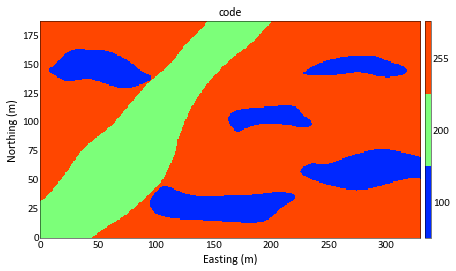

In [13]:
gs.slice_plot(df, griddef=grid, var='code', figsize=(7,7), catdata=True, output_file='exhaustive', cmap='jet')

In [14]:
gs.write_gslib(df, 'exhaust.dat')

In [15]:
random_sampling = df.sample(frac=0.003, replace=True)

In [16]:
regular_sampling = pd.DataFrame(columns=['x','y','code'])

In [17]:
x_int = 25
y_int = 25

row_list = []

for x in range(0, x_size, x_int):
    for y in range(0, y_size, y_int):
        row = df.loc[(df['x'] == x) & (df['y'] == y)]

        regular_sampling = regular_sampling.append(row, ignore_index=True)

In [18]:
random_sampling.head()

,x,y,code
51732,252,31,255
51524,44,31,200
46919,59,45,200
40716,126,64,255
14567,47,143,100


In [19]:
regular_sampling.head()

,x,y,code
0,0,0,200
1,0,25,200
2,0,50,255
3,0,75,255
4,0,100,255


In [20]:
full = pd.concat([random_sampling, regular_sampling])

In [21]:
f1 = full['code'] == 100
f2 = full['code'] == 200
f3 = full['code'] == 255
f = f1 | f2 | f3

In [22]:
full = full[f]

In [23]:
full.to_csv('dataset.csv', index=False)

In [24]:
data = gs.DataFile(flname='dataset.csv', x='x', y='y', fltype='csv')

In [25]:
len(data)

298

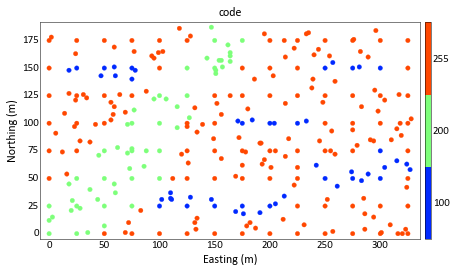

In [26]:
gs.location_plot(data=data, x='x', y='y', cmap='jet', z=None, figsize=(7,7), output_file='sampled_irr')

In [27]:
def ijk_in_n(grid, i, j, k=0):
    dims = [grid.grid_array[0], grid.grid_array[3], grid.grid_array[6]]
    n = k*dims[0]*dims[1]+j*dims[0]+i
    return n

In [28]:
def drill_holes_sampling(datafile, griddef, n_holes, step=1, regular=True):
    n_x = griddef.grid_array[0]
    n_y = griddef.grid_array[0]
    if regular != True:
        r_indexes = np.random.randint(low=0, high=n_x, size=n_holes)
    else:
        r_indexes = np.arange(0, n_x, int(n_x/n_holes))
    print(r_indexes)
    grid_indexes = []
    for i in r_indexes:
        for j in range(0, griddef.grid_array[3], step):
            grid_indexes.append(ijk_in_n(grid=griddef, i=i, j=j))
            
    filtered_data = datafile.iloc[grid_indexes]
    return filtered_data

In [29]:
a = drill_holes_sampling(datafile=df, griddef=grid, n_holes=12, regular=True, step=4)

[  0  27  54  81 108 135 162 189 216 243 270 297 324]


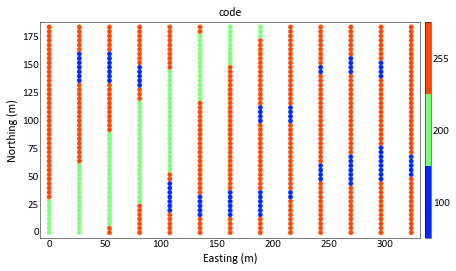

In [30]:
gs.location_plot(data=a, x='x', y='y', z=None, var='code', cmap='jet', figsize=(7,7), output_file='sampled')

In [31]:
gs.write_gslib(a, 'holes.dat')